# Телеком



<h3>Прогноз оттока клиентов для оператора связи<span class="tocSkip"></span></h3>


На основе информации о клиентах оператора связи, построить модель способную прогнозировать отток.

<font color='' size=3><b>Цель:</b></font>

Цель: Оператору связи необходимо научиться прогнозировать отток клиентов для планирования предиктивных мер (скидок, особых условий).

<font color='' size=3><b>Описание услуг</b></font>

Оператор предоставляет два основных типа услуг:

<b>Стационарную телефонную связь.</b>Возможно подключение телефонного аппарата к нескольким линиям одновременно.

  <b>Интернет.</b>Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

<b>Интернет-безопасность:</b>антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);

<b>Выделенная линия технической поддержки (TechSupport)</b>;

<b>Облачное хранилище файлов для резервного копирования данных (OnlineBackup)</b>;

<b>Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies)</b>.

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. 
Доступны различные способы расчёта и возможность получения электронного чека.


<font color='' size=3><b>Описание данных</b></font>

Данные состоят из файлов, полученных из разных источников:

contract.csv — информация о договоре;
personal.csv — персональные данные клиента;
internet.csv — информация об интернет-услугах;
phone.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

<font color='' size=3><b>Расшифровка колонок</b></font>

customerID - идентификационный номер клиента

BeginDate - дата начала пользования услугами

EndDate - дата окончания пользования услугами

Type - тип оплаты: ежемесячный, годовой и тд

PaperlessBilling – безналичный расчет

PaymentMethod – способ оплаты

MonthlyCharges – ежемесячные траты на услуги

TotalCharges – всего потрачено денег на услуги

Dependents – наличие иждивенцев

Senior Citizen – наличие пенсионного статуса по возрасту

Partner – наличие супруга(и)

MultipleLines – наличие возможности ведения параллельных линий во время звонка


<h3>План выполнения проекта<span class="tocSkip"></span></h3>

1.Исследование данных

-визуальный осмотр

-вывод статистической информации

-поиск пропусков и проверка типов данных

-поиск дубликатов

2.Подготовка данных

-объединение таблиц

-пред обработка пропусков, дубликатов (при наличии)

-изменение типов данных (при необходимости)

-подготовка признаков для модели(добавление синтетических, удаление малоинформативных)

3.Подбор моделей

-обучить и сравнить несколько моделей на кросс валидации, и выбрать наиболее подходящую

4.Подбор гиперпараметров и признакового пространства на кросс валидации

-выбрать информативные признаки

-подобрать гиперпараметры

5.Тестирование

-проверка на тестовой выборке

6.Вывод

 <font color='' size=3><b>Импорт библиотек</b></font>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import chi2_contingency

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, roc_curve, confusion_matrix

from lightgbm import LGBMClassifier

alpha = 0.05

import matplotlib.pyplot as plt
import seaborn as sns
import warnings


pd.set_option('display.max_columns', 30)
warnings.filterwarnings("ignore")

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col='customerID')
personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col='customerID')
internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col='customerID')
phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col='customerID')

datasets = [contract, personal, internet, phone]

## Исследование данных

In [3]:
def view(data):
    print('Обзор данных', '\n')
    print(data.sample(10))
    print('\n')
    print('Информация о формате, количестве строк и пропусках', '\n')
    print(data.info())
    print('\n')
    print('Статистика', '\n')
    print(data.describe())
    print('-' * 65)
    print('\n' * 3)

<font color='' size=3><b>contract</b></font>  

In [4]:
view(contract)

Обзор данных 

             BeginDate              EndDate            Type PaperlessBilling  \
customerID                                                                     
5419-JKZNQ  2017-08-01                   No  Month-to-month               No   
0516-WJVXC  2019-08-01  2020-01-01 00:00:00  Month-to-month               No   
5524-KHNJP  2017-05-01                   No        One year               No   
4627-MIHJH  2014-05-01                   No        Two year               No   
9139-TWBAS  2017-12-01                   No        One year               No   
6689-VRRTK  2016-06-01                   No        One year              Yes   
1212-GLHMD  2019-11-01                   No  Month-to-month              Yes   
1169-WCVAK  2018-07-01                   No  Month-to-month              Yes   
4290-BSXUX  2019-07-01  2019-10-01 00:00:00  Month-to-month              Yes   
2057-ZBLPD  2018-02-01  2019-11-01 00:00:00  Month-to-month              Yes   

                        

<font color='' size=3><b>personal</b></font>

In [5]:
view(personal)

Обзор данных 

            gender  SeniorCitizen Partner Dependents
customerID                                          
8645-KOMJQ    Male              0     Yes        Yes
7235-NXZCP    Male              1      No         No
0531-ZZJWQ    Male              1     Yes         No
7993-NQLJE    Male              0     Yes        Yes
9221-OTIVJ  Female              1      No         No
7131-ZQZNK  Female              0     Yes        Yes
2511-MORQY    Male              0     Yes        Yes
6371-NZYEG    Male              0     Yes        Yes
6838-YAUVY  Female              0      No         No
0679-TDGAK    Male              0     Yes        Yes


Информация о формате, количестве строк и пропусках 

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   P

<font color='' size=3><b>internet</b></font>

In [6]:
view(internet)

Обзор данных 

           InternetService OnlineSecurity OnlineBackup DeviceProtection  \
customerID                                                                
8650-RHRKE             DSL             No           No              Yes   
4208-UFFGW             DSL             No           No               No   
7465-ZZRVX     Fiber optic             No           No               No   
1455-ESIQH     Fiber optic             No           No               No   
1400-WIVLL     Fiber optic             No           No              Yes   
1568-LJSZU             DSL            Yes          Yes              Yes   
3748-FVMZZ             DSL             No           No               No   
1480-IVEVR     Fiber optic             No           No              Yes   
3472-OAOOR             DSL            Yes          Yes               No   
8490-BXHEO     Fiber optic             No          Yes               No   

           TechSupport StreamingTV StreamingMovies  
customerID                     

<font color='' size=3><b>phone</b></font>

In [7]:
view(phone)

Обзор данных 

           MultipleLines
customerID              
4763-PGDPO            No
4163-HFTUK            No
6972-SNKKW            No
1899-VXWXM           Yes
9402-CXWPL           Yes
7941-RCJOW            No
4529-CKBCL            No
0415-MOSGF            No
7730-IUTDZ            No
4918-FYJNT           Yes


Информация о формате, количестве строк и пропусках 

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB
None


Статистика 

       MultipleLines
count           6361
unique             2
top               No
freq            3390
-----------------------------------------------------------------






<font color='' size=4><b>Выводы</b></font>

- Пропусков в данных нет. 
- Колонку total charges следует привести к числовому формату. 
- Следует создать бинарный целевой признак. 
- Дата начала пользования услугами будет плохо масштабироваться в будущее, нужно на ее основе создать новый признак или исключить.

## Подготовка данных 

Добавим признаки, указывающие на пользование клиентом интернетом и на пользование телефоном.

In [8]:
datasets[2]['internet'] = 'Yes'
datasets[3]['phone'] = 'Yes'

Объединим датафреймы по индексу

In [9]:
df = contract.join(datasets[1:]).reset_index()

После объединения проверим на наличие дубликатов

In [10]:
df.duplicated().sum()

0

Дубликатов нет

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Есть пропуски, обусловленные неиспользованием ряда услуг,заменяем пропуски на 'No'.

In [12]:
df = df.fillna('No')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


Избавились от пропусков.Посмотрим на признак 'TotalCharges'

In [14]:
df.loc[df['TotalCharges']==' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,Yes,No,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,No,No,No,No,No,No,No,No,No,Yes
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,Yes,No,Yes
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,Yes,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,No,Yes
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,Yes,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,No,No,No,No,No,No,No,No,No,Yes
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,No,Yes
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes


11 клиентов подключились в день сбора данных 2020-02-01 и по ним еще нет данных об общих платежах, удалим их. На этапе подготовки данных для модели, мы не сможем  ни протестировать на них, ни собрать полезную информацию, они вносят только шум.

In [15]:
df = df.loc[df['TotalCharges']!=' ']

Проверим результат

In [16]:
df.loc[df['BeginDate'] >= '2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone


Неразмеченные данные удалены.

In [17]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [18]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'])

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   object        
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7032 non-null   object        
 9   SeniorCitizen     7032 non-null   int64         
 10  Partner           7032 non-null   object        
 11  Dependents        7032 non-null   object        
 12  InternetService   7032 non-null   object        
 13  OnlineSecurity    7032 non-null   object        
 14  OnlineBackup      7032 n

In [20]:
gone = df.loc[df['EndDate'] != 'No']

In [21]:
stayed = df.loc[df['EndDate'] == 'No']

In [22]:
gone['EndDate'] = pd.to_datetime(gone['EndDate'])

In [23]:
gone['together'] = round((gone['EndDate'] - gone['BeginDate'])/np.timedelta64(1, 'D'))

In [24]:
gone['MonthlyCharges'].describe()

count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

In [25]:
df['MonthlyCharges'].describe()

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

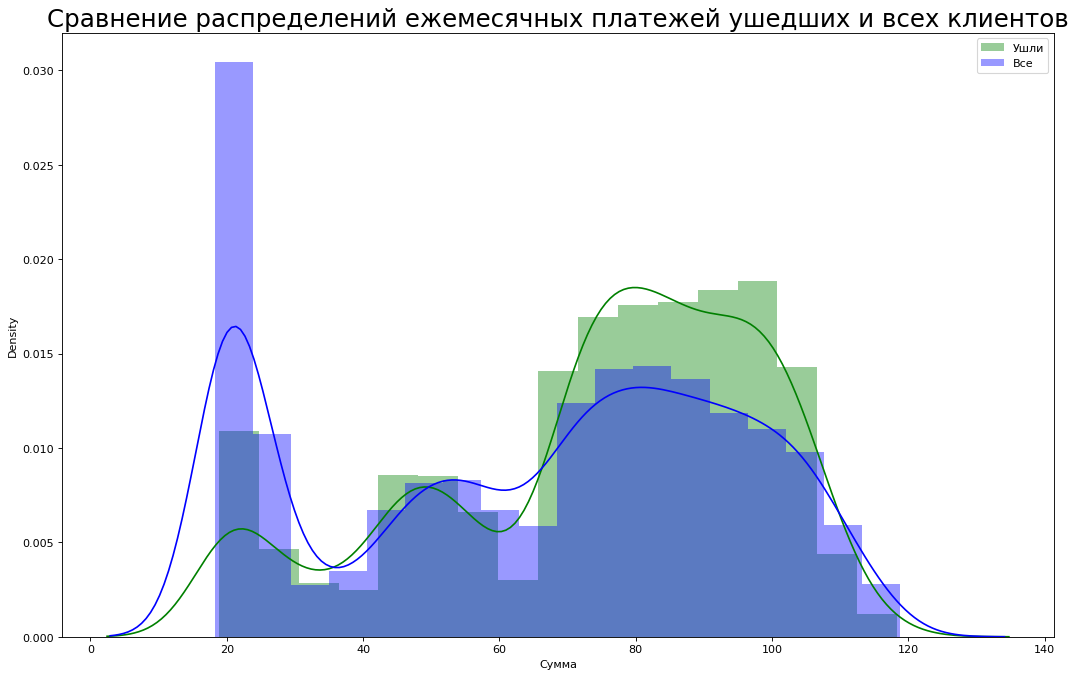

In [26]:
plt.figure(figsize=(16,10), dpi= 80)
sns.distplot(gone['MonthlyCharges'], color="g", label="Ушли")
sns.distplot(df['MonthlyCharges'], color="b", label="Все")

plt.title('Сравнение распределений ежемесячных платежей ушедших и всех клиентов', fontsize=22)
plt.legend()
plt.xlabel('Сумма')
plt.show()

Диаграммы показывают, что чаще уходят клиенты у которых ежемесячные траты выше. Полимодальное распределение с тремя модами позволяет предположить, что есть три базовых тарифа. Клиенты тратящие больше уходят чаще.

In [27]:
gone['together'].describe()

count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: together, dtype: float64

Четверть уходящих клиентов, уходят в первый месяц, половина в первые 10 месяцев

## Подбор моделей

Будем использовать следующие модели: LogisticRegression, RandomForestClassifier и LGBMClassifier. 

### Подготовка к обучению моделей

Удалим позднее номера клиентов, в связи с неинформативностью признака

In [28]:
#df = df.drop(columns='customerID')

Создаём бинарный целевой признак

In [29]:
df.loc[df['EndDate'] != 'No', 'left'] = 1
df.loc[df['EndDate'] == 'No', 'left'] = 0  
df['left'] = df['left'].astype(int)

In [30]:
df.loc[df['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
df['EndDate'] = pd.to_datetime(df['EndDate'])
df['together'] = round((df['EndDate'] - df['BeginDate'])/np.timedelta64(1, 'D')).astype(int)
df = df.drop(columns=['EndDate', 'BeginDate'])

In [31]:
df.together.sort_values()

2133      30
6623      30
3310      30
6633      30
248       30
        ... 
850     2191
6778    2191
2941    2191
4513    2191
932     2191
Name: together, Length: 7032, dtype: int64

In [32]:
df[df.together < 50]

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone,left,together
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,Yes,No,No,0,31
20,8779-QRDMV,Month-to-month,Yes,Electronic check,39.65,39.65,Male,1,No,No,DSL,No,No,Yes,No,No,Yes,Yes,No,No,1,30
22,1066-JKSGK,Month-to-month,No,Mailed check,20.15,20.15,Male,0,No,No,No,No,No,No,No,No,No,No,No,Yes,1,30
27,8665-UTDHZ,Month-to-month,No,Electronic check,30.20,30.20,Male,0,Yes,Yes,DSL,No,Yes,No,No,No,No,Yes,No,No,1,30
33,7310-EGVHZ,Month-to-month,No,Bank transfer (automatic),20.20,20.20,Male,0,No,No,No,No,No,No,No,No,No,No,No,Yes,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6979,5351-QESIO,Month-to-month,No,Mailed check,24.20,24.20,Male,0,No,Yes,DSL,No,No,No,No,No,No,Yes,No,No,0,31
7010,0723-DRCLG,Month-to-month,Yes,Electronic check,74.45,74.45,Female,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes,Yes,Yes,1,30
7016,1471-GIQKQ,Month-to-month,No,Electronic check,49.95,49.95,Female,0,No,No,DSL,No,Yes,No,No,No,No,Yes,No,Yes,0,31
7018,1122-JWTJW,Month-to-month,Yes,Mailed check,70.65,70.65,Male,0,Yes,Yes,Fiber optic,No,No,No,No,No,No,Yes,No,Yes,1,31


Посчитали сколько клиент с нами. BeginDate, EndDate нам больше не нужны мы извлекли из них всю полезную информацию.

In [33]:
df.describe(include='all')

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone,left,together
count,7032,7032,7032,7032,7032.000000,7032.000000,7032,7032.000000,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032.000000,7032.000000
unique,7032,3,2,4,NaN,NaN,2,NaN,2,2,3,2,2,2,2,2,2,2,2,2,NaN,NaN
top,4760-XOHVN,Month-to-month,Yes,Electronic check,NaN,NaN,Male,NaN,No,No,Fiber optic,No,No,No,No,No,No,Yes,No,Yes,NaN,NaN
freq,1,3875,4168,2365,NaN,NaN,3549,NaN,3639,4933,3096,5017,4607,4614,4992,4329,4301,5512,4065,6352,NaN,NaN
mean,NaN,NaN,NaN,NaN,64.798208,2283.300441,NaN,0.162400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.265785,987.538538
std,NaN,NaN,NaN,NaN,30.085974,2266.771362,NaN,0.368844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.441782,747.153663
min,NaN,NaN,NaN,NaN,18.250000,18.800000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,30.000000
25%,NaN,NaN,NaN,NaN,35.587500,401.450000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,275.000000
50%,NaN,NaN,NaN,NaN,70.350000,1397.475000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,883.000000
75%,NaN,NaN,NaN,NaN,89.862500,3794.737500,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1676.000000


In [34]:
def cat_type(df, col):
    print(col)
    print(df[col].unique())
    print()
    return df

In [35]:
categorial = ['Type', 'InternetService', 'Partner', 'DeviceProtection', 'gender', 
              'OnlineBackup', 'Dependents','PaperlessBilling', 'StreamingTV',
              'MultipleLines', 'SeniorCitizen', 'TechSupport','OnlineSecurity',
              'StreamingMovies', 'PaymentMethod','phone', 'internet']

In [36]:
categorial

['Type',
 'InternetService',
 'Partner',
 'DeviceProtection',
 'gender',
 'OnlineBackup',
 'Dependents',
 'PaperlessBilling',
 'StreamingTV',
 'MultipleLines',
 'SeniorCitizen',
 'TechSupport',
 'OnlineSecurity',
 'StreamingMovies',
 'PaymentMethod',
 'phone',
 'internet']

In [37]:
for i in categorial:
    cat_type(df, i)

Type
['Month-to-month' 'One year' 'Two year']

InternetService
['DSL' 'Fiber optic' 'No']

Partner
['Yes' 'No']

DeviceProtection
['No' 'Yes']

gender
['Female' 'Male']

OnlineBackup
['Yes' 'No']

Dependents
['No' 'Yes']

PaperlessBilling
['Yes' 'No']

StreamingTV
['No' 'Yes']

MultipleLines
['No' 'Yes']

SeniorCitizen
[0 1]

TechSupport
['No' 'Yes']

OnlineSecurity
['No' 'Yes']

StreamingMovies
['No' 'Yes']

PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

phone
['No' 'Yes']

internet
['Yes' 'No']



Посмотрим, как влияют признаки на целевой признак - факт ухода клиента. Воспользуемся chi2_contingency для определения статистической значимости различий ушедших и оставшихся клиентов.

Для лаконичности создадим функцию, принимающую на вход столбец, по которому нужна группировка. Функция будет строить таблицу с количеством ушедших и оставшихся клиентов, сгруппированных по нужному признаку, вычислять значение статистики и делать вывод о влиянии признака на уход клиента из компании.

In [38]:
def table_for_chi2(col_group):
    table1 = df.groupby(col_group, as_index=False)['left'].sum()
    table2 = df.groupby(col_group, as_index=False)['customerID'].count()
    merge = table1.merge(table2, on=col_group)
    merge.rename(columns = {'customerID':'all'}, inplace = True)
    merge['not_left'] = merge['all'] - merge['left']
    merge = merge.drop('all', axis=1)
        
    stat, p, dof, expected = chi2_contingency(merge[['left', 'not_left']])
      
    return merge, p

Сформулируем гипотезу:

H0: признак не связан с оттоком клиентов;
H1: признак связан с оттоком клиентов.
Примем значение порога статистической значимости alpha = 0.05.

Вызовем функцию для всех категориальных столбцов:

In [39]:
categorial = ['Type', 'InternetService', 'Partner', 'DeviceProtection', #'gender', 
              'OnlineBackup', 'Dependents','PaperlessBilling', 'StreamingTV',
              'MultipleLines', 'SeniorCitizen', 'TechSupport','OnlineSecurity',
              'StreamingMovies', 'PaymentMethod',
              #'phone', 
              'internet']

In [40]:
df

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone,left,together
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,Yes,No,No,0,31
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,Yes,No,Yes,0,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,Yes,No,Yes,1,61
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,Yes,No,No,0,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,Yes,No,Yes,1,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,One year,Yes,Mailed check,84.80,1990.50,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0,730
7039,2234-XADUH,One year,Yes,Credit card (automatic),103.20,7362.90,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,0,2191
7040,4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,Yes,No,No,0,337
7041,8361-LTMKD,Month-to-month,Yes,Mailed check,74.40,306.60,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes,Yes,Yes,1,123


,Type,left,not_left
0,Month-to-month,1655,2220
1,One year,166,1306
2,Two year,48,1637


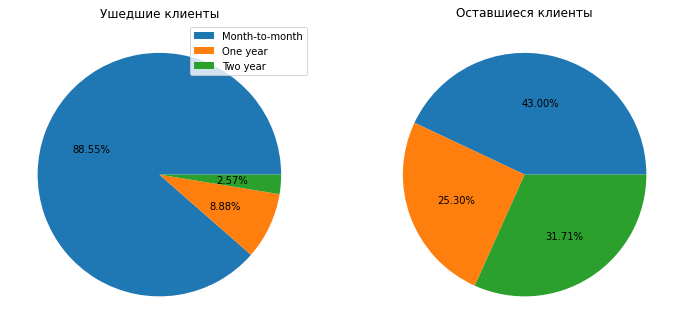

p-значение: 7.326182186264635e-257
Отклонить нулевую гипотезу


,InternetService,left,not_left
0,DSL,459,1957
1,Fiber optic,1297,1799
2,No,113,1407


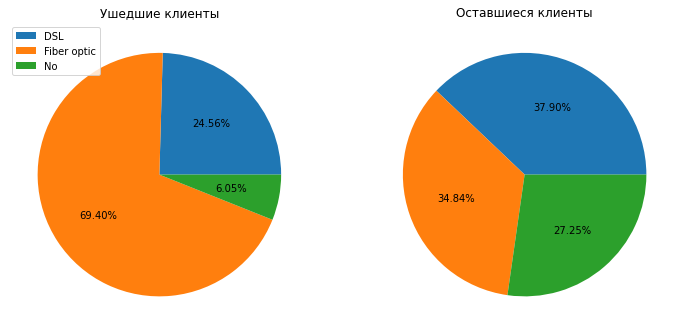

p-значение: 5.831198962237274e-159
Отклонить нулевую гипотезу


,Partner,left,not_left
0,No,1200,2439
1,Yes,669,2724


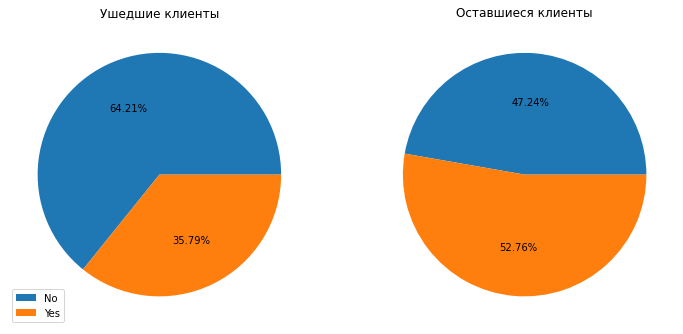

p-значение: 3.97379757451591e-36
Отклонить нулевую гипотезу


,DeviceProtection,left,not_left
0,No,1324,3290
1,Yes,545,1873


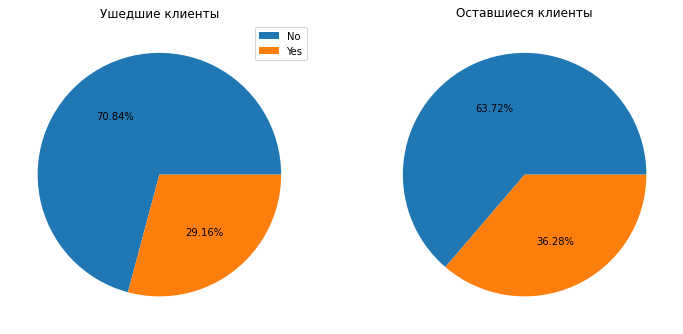

p-значение: 3.346074945648784e-08
Отклонить нулевую гипотезу


,OnlineBackup,left,not_left
0,No,1346,3261
1,Yes,523,1902


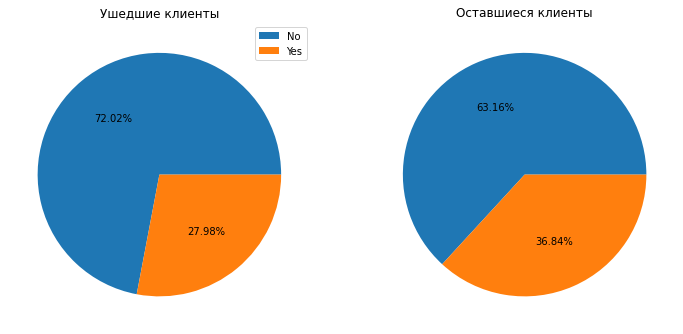

p-значение: 6.259257129714726e-12
Отклонить нулевую гипотезу


,Dependents,left,not_left
0,No,1543,3390
1,Yes,326,1773


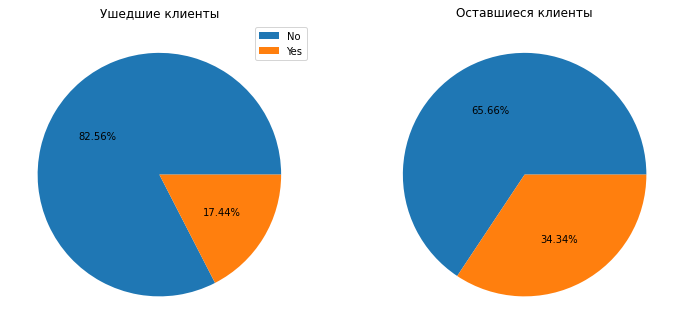

p-значение: 2.0196592017051303e-42
Отклонить нулевую гипотезу


,PaperlessBilling,left,not_left
0,No,469,2395
1,Yes,1400,2768


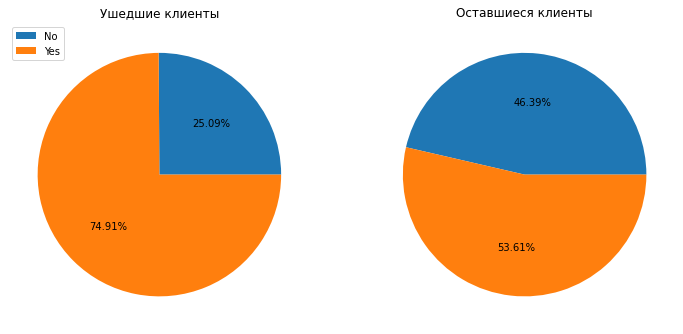

p-значение: 8.236203353962564e-58
Отклонить нулевую гипотезу


,StreamingTV,left,not_left
0,No,1055,3274
1,Yes,814,1889


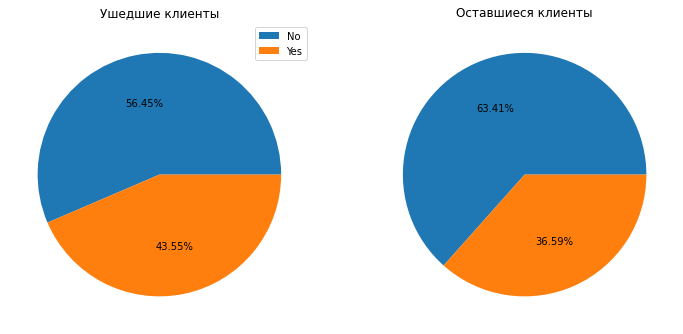

p-значение: 1.3164336109407092e-07
Отклонить нулевую гипотезу


,MultipleLines,left,not_left
0,No,1019,3046
1,Yes,850,2117


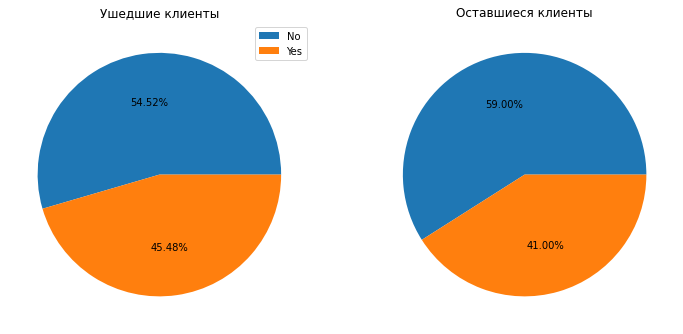

p-значение: 0.0008694082815826175
Отклонить нулевую гипотезу


,SeniorCitizen,left,not_left
0,0,1393,4497
1,1,476,666


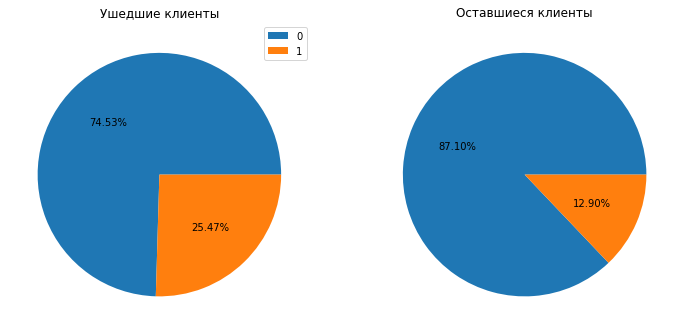

p-значение: 2.4792557203954705e-36
Отклонить нулевую гипотезу


,TechSupport,left,not_left
0,No,1559,3433
1,Yes,310,1730


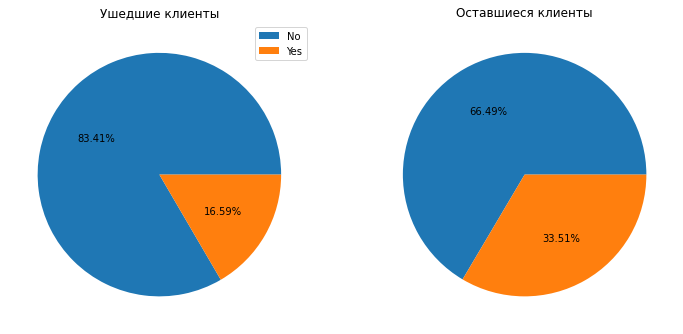

p-значение: 3.232868325549167e-43
Отклонить нулевую гипотезу


,OnlineSecurity,left,not_left
0,No,1574,3443
1,Yes,295,1720


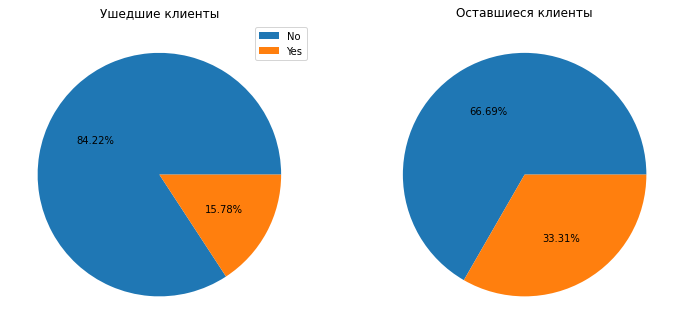

p-значение: 1.37424000884718e-46
Отклонить нулевую гипотезу


,StreamingMovies,left,not_left
0,No,1051,3250
1,Yes,818,1913


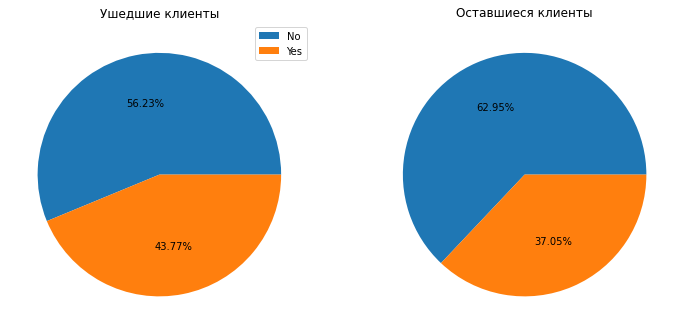

p-значение: 3.857900347663822e-07
Отклонить нулевую гипотезу


,PaymentMethod,left,not_left
0,Bank transfer (automatic),258,1284
1,Credit card (automatic),232,1289
2,Electronic check,1071,1294
3,Mailed check,308,1296


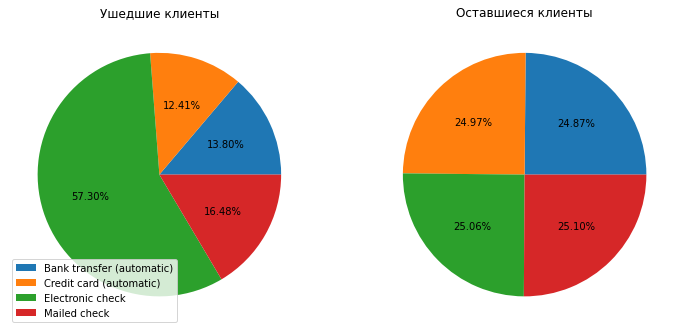

p-значение: 1.4263098511063342e-139
Отклонить нулевую гипотезу


,internet,left,not_left
0,No,113,1407
1,Yes,1756,3756


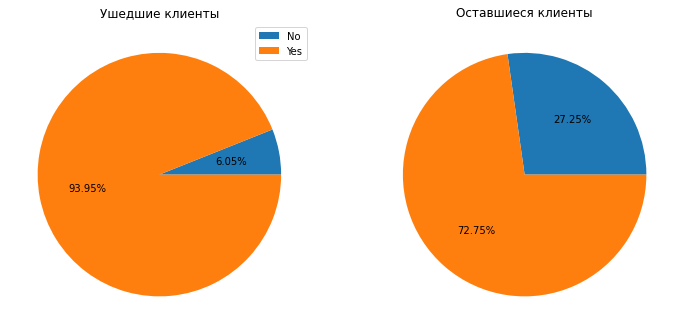

p-значение: 6.4225207979072035e-81
Отклонить нулевую гипотезу


In [41]:
for col in categorial:
    table_chi2, p_chi2 = table_for_chi2(col)
    display(table_chi2)
    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 2, 1)
    plt.pie(table_chi2['left'], autopct='%1.2f%%')
    plt.legend(labels=table_chi2[col], loc='best')
    plt.title('Ушедшие клиенты')
   
    
    plt.subplot(1, 2, 2)
    plt.pie(table_chi2['not_left'], autopct='%1.2f%%')
    plt.title('Оставшиеся клиенты')
    plt.show()
    print('p-значение:', p_chi2)
    if p_chi2 < alpha:
        print('Отклонить нулевую гипотезу')
    else:
        print('Не получилось отклонить нулевую гипотезу')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   Type              7032 non-null   object 
 2   PaperlessBilling  7032 non-null   object 
 3   PaymentMethod     7032 non-null   object 
 4   MonthlyCharges    7032 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   gender            7032 non-null   object 
 7   SeniorCitizen     7032 non-null   int64  
 8   Partner           7032 non-null   object 
 9   Dependents        7032 non-null   object 
 10  InternetService   7032 non-null   object 
 11  OnlineSecurity    7032 non-null   object 
 12  OnlineBackup      7032 non-null   object 
 13  DeviceProtection  7032 non-null   object 
 14  TechSupport       7032 non-null   object 
 15  StreamingTV       7032 non-null   object 
 16  StreamingMovies   7032 non-null   object 


Не получилось отклонить нулевую гипотезу по признакам gender и phone. Можно удалить их из датафрейма, так как они не информативны. Все остальные признаки значимы.

In [43]:
df

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone,left,together
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,Yes,No,No,0,31
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,Yes,No,Yes,0,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,Yes,No,Yes,1,61
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,Yes,No,No,0,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,Yes,No,Yes,1,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,One year,Yes,Mailed check,84.80,1990.50,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0,730
7039,2234-XADUH,One year,Yes,Credit card (automatic),103.20,7362.90,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,0,2191
7040,4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,Yes,No,No,0,337
7041,8361-LTMKD,Month-to-month,Yes,Mailed check,74.40,306.60,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes,Yes,Yes,1,123


Вычислим коэффициент корреляции для близких по смыслу признаков

In [44]:
df['MonthlyCharges'].corr(df['TotalCharges'])

0.6510648032262024

In [45]:
df = df.drop(columns=['customerID', 'gender','phone',
                     'TotalCharges'])

In [46]:
df

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,left,together
0,Month-to-month,Yes,Electronic check,29.85,0,Yes,No,DSL,No,Yes,No,No,No,No,Yes,No,0,31
1,One year,No,Mailed check,56.95,0,No,No,DSL,Yes,No,Yes,No,No,No,Yes,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,0,No,No,DSL,Yes,Yes,No,No,No,No,Yes,No,1,61
3,One year,No,Bank transfer (automatic),42.30,0,No,No,DSL,Yes,No,Yes,Yes,No,No,Yes,No,0,1371
4,Month-to-month,Yes,Electronic check,70.70,0,No,No,Fiber optic,No,No,No,No,No,No,Yes,No,1,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,One year,Yes,Mailed check,84.80,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,0,730
7039,One year,Yes,Credit card (automatic),103.20,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,Yes,0,2191
7040,Month-to-month,Yes,Electronic check,29.60,0,Yes,Yes,DSL,Yes,No,No,No,No,No,Yes,No,0,337
7041,Month-to-month,Yes,Mailed check,74.40,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes,Yes,1,123


In [47]:
one_class_waight = df.loc[df['left'] == 1].shape[0] / df['left'].shape[0]
zero_class_waight = 1 - one_class_waight
class_waights = [ one_class_waight, zero_class_waight]
class_waights

[0.26578498293515357, 0.7342150170648465]

Есть существенный дисбаланс классов целевого признака. Создали список весов, для передачи в Catboost

In [48]:
df

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,left,together
0,Month-to-month,Yes,Electronic check,29.85,0,Yes,No,DSL,No,Yes,No,No,No,No,Yes,No,0,31
1,One year,No,Mailed check,56.95,0,No,No,DSL,Yes,No,Yes,No,No,No,Yes,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,0,No,No,DSL,Yes,Yes,No,No,No,No,Yes,No,1,61
3,One year,No,Bank transfer (automatic),42.30,0,No,No,DSL,Yes,No,Yes,Yes,No,No,Yes,No,0,1371
4,Month-to-month,Yes,Electronic check,70.70,0,No,No,Fiber optic,No,No,No,No,No,No,Yes,No,1,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,One year,Yes,Mailed check,84.80,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,0,730
7039,One year,Yes,Credit card (automatic),103.20,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,Yes,0,2191
7040,Month-to-month,Yes,Electronic check,29.60,0,Yes,Yes,DSL,Yes,No,No,No,No,No,Yes,No,0,337
7041,Month-to-month,Yes,Mailed check,74.40,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes,Yes,1,123


In [49]:
#df_ohe = pd.get_dummies(df, drop_first=True).astype(int)ho

In [50]:
#df_ohe

In [51]:
#df_ohe = df_ohe.drop(columns=['Partner_Yes', 'DeviceProtection_Yes',
 #                     'internet_Yes', 'OnlineBackup_Yes','Dependents_Yes', 
 #                     'PaperlessBilling_Yes','OnlineSecurity_Yes', 'StreamingTV_Yes', 
  #                    'StreamingMovies_Yes', 'MultipleLines_Yes'])

<div class="alert alert-warning">
<b>⚠️ Комментарий ревьювера:</b> Почему решил избавиться от некоторых признаков? Лучше это сделать до кодирования, на основе матрицы корреляции
    
</div>

In [52]:
##
df_ohe = df.copy()

<div class="alert alert-warning">
<b>⚠️ Комментарий ревьювера v2:</b> Нужно быть аккуратным с присаиванием переменных. Лучше сделать таким образом:
    
    df_ohe = df.copy()
    
Дело в том, что в python ссылочная структура данных, сооветственно изменения в df_ohe будут происходить также в df
    
</div>

In [53]:
target= df_ohe['left']
features= df_ohe.drop('left', axis=1)

In [54]:
numeric = ['MonthlyCharges', 'together']
#ohe_enc = OneHotEncoder(drop = 'first', handle_unknown = 'error')
#ohe_enc.fit(features[categorial])
#new_columns = ohe_enc.get_feature_names(categorial)
#features_ohe = pd.DataFrame(ohe_enc.transform(features[categorial]).toarray(), 
#                         columns = new_columns, index = features.index)
#features_ohe = features_ohe.join(features[numeric])

Отделили целевой признак

In [55]:

features

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,together
0,Month-to-month,Yes,Electronic check,29.85,0,Yes,No,DSL,No,Yes,No,No,No,No,Yes,No,31
1,One year,No,Mailed check,56.95,0,No,No,DSL,Yes,No,Yes,No,No,No,Yes,No,1036
2,Month-to-month,Yes,Mailed check,53.85,0,No,No,DSL,Yes,Yes,No,No,No,No,Yes,No,61
3,One year,No,Bank transfer (automatic),42.30,0,No,No,DSL,Yes,No,Yes,Yes,No,No,Yes,No,1371
4,Month-to-month,Yes,Electronic check,70.70,0,No,No,Fiber optic,No,No,No,No,No,No,Yes,No,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,One year,Yes,Mailed check,84.80,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,730
7039,One year,Yes,Credit card (automatic),103.20,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,Yes,2191
7040,Month-to-month,Yes,Electronic check,29.60,0,Yes,Yes,DSL,Yes,No,No,No,No,No,Yes,No,337
7041,Month-to-month,Yes,Mailed check,74.40,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes,Yes,123


In [56]:
target= df_ohe['left']

In [57]:

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features, target,
                                                                              test_size = 0.25,
                                                                              random_state = 270223,
                                                                              stratify = target,
                                                                              shuffle = True)

In [58]:
features_train_ohe

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,together
4136,One year,No,Bank transfer (automatic),19.90,0,Yes,No,No,No,No,No,No,No,No,No,No,1432
1811,Month-to-month,Yes,Mailed check,79.35,1,No,No,Fiber optic,No,No,Yes,No,No,No,Yes,Yes,702
4906,Two year,Yes,Bank transfer (automatic),95.90,0,Yes,Yes,Fiber optic,Yes,Yes,No,No,Yes,No,Yes,Yes,2191
7033,Month-to-month,Yes,Credit card (automatic),69.50,0,No,No,Fiber optic,No,No,No,No,No,No,Yes,No,1157
2642,Month-to-month,Yes,Electronic check,85.30,0,Yes,No,Fiber optic,No,No,Yes,No,No,Yes,Yes,No,1430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6503,One year,No,Electronic check,60.35,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,Yes,Yes,No,2132
882,Month-to-month,No,Electronic check,83.90,0,No,No,Fiber optic,No,No,Yes,No,No,Yes,Yes,No,183
4279,Month-to-month,Yes,Bank transfer (automatic),25.40,0,Yes,Yes,No,No,No,No,No,No,No,No,Yes,761
481,Month-to-month,Yes,Bank transfer (automatic),45.30,0,Yes,No,DSL,Yes,No,Yes,No,No,Yes,Yes,No,1461


Разбили на трейн, тест

In [59]:
categorial_ohe = ['Type', 'InternetService', 'Partner', 'DeviceProtection', 
              'OnlineBackup', 'Dependents','PaperlessBilling', 'StreamingTV',
              'MultipleLines', 'SeniorCitizen', 'TechSupport','OnlineSecurity',
              'StreamingMovies', 'PaymentMethod', 'internet']

In [60]:
categorial_ohe= ['Type', 'InternetService', 'Partner', 'DeviceProtection', 
              'OnlineBackup', 'Dependents','PaperlessBilling', 'StreamingTV',
              'MultipleLines', 'SeniorCitizen', 'TechSupport','OnlineSecurity',
              'StreamingMovies', 'PaymentMethod', 'internet']
for col in categorial_ohe:
    df[categorial_ohe] = df[categorial_ohe].astype('category')

In [61]:
categorial_ohe

['Type',
 'InternetService',
 'Partner',
 'DeviceProtection',
 'OnlineBackup',
 'Dependents',
 'PaperlessBilling',
 'StreamingTV',
 'MultipleLines',
 'SeniorCitizen',
 'TechSupport',
 'OnlineSecurity',
 'StreamingMovies',
 'PaymentMethod',
 'internet']

In [62]:
features_train_ohe

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,together
4136,One year,No,Bank transfer (automatic),19.90,0,Yes,No,No,No,No,No,No,No,No,No,No,1432
1811,Month-to-month,Yes,Mailed check,79.35,1,No,No,Fiber optic,No,No,Yes,No,No,No,Yes,Yes,702
4906,Two year,Yes,Bank transfer (automatic),95.90,0,Yes,Yes,Fiber optic,Yes,Yes,No,No,Yes,No,Yes,Yes,2191
7033,Month-to-month,Yes,Credit card (automatic),69.50,0,No,No,Fiber optic,No,No,No,No,No,No,Yes,No,1157
2642,Month-to-month,Yes,Electronic check,85.30,0,Yes,No,Fiber optic,No,No,Yes,No,No,Yes,Yes,No,1430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6503,One year,No,Electronic check,60.35,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,Yes,Yes,No,2132
882,Month-to-month,No,Electronic check,83.90,0,No,No,Fiber optic,No,No,Yes,No,No,Yes,Yes,No,183
4279,Month-to-month,Yes,Bank transfer (automatic),25.40,0,Yes,Yes,No,No,No,No,No,No,No,No,Yes,761
481,Month-to-month,Yes,Bank transfer (automatic),45.30,0,Yes,No,DSL,Yes,No,Yes,No,No,Yes,Yes,No,1461


In [63]:
features_test_ohe

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,together
200,One year,Yes,Credit card (automatic),101.90,0,Yes,No,Fiber optic,Yes,No,No,Yes,Yes,Yes,Yes,No,822
6990,Month-to-month,Yes,Electronic check,93.60,0,Yes,No,Fiber optic,Yes,No,No,No,Yes,Yes,Yes,No,1095
4926,Two year,Yes,Credit card (automatic),60.15,0,Yes,No,DSL,No,Yes,Yes,Yes,No,No,Yes,No,1888
6912,Month-to-month,Yes,Electronic check,85.50,0,No,No,Fiber optic,No,No,No,No,Yes,No,Yes,Yes,276
5685,Two year,No,Electronic check,19.20,0,Yes,Yes,No,No,No,No,No,No,No,No,No,1371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2834,One year,No,Mailed check,20.25,0,Yes,Yes,No,No,No,No,No,No,No,No,No,1279
5452,One year,No,Bank transfer (automatic),75.10,0,Yes,Yes,DSL,Yes,Yes,No,No,Yes,Yes,Yes,No,1126
6541,Two year,No,Mailed check,20.50,0,No,Yes,No,No,No,No,No,No,No,No,No,580
6728,Two year,No,Electronic check,115.15,0,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2191


In [64]:
ohe_enc = OneHotEncoder(drop = 'first', handle_unknown = 'error')
ohe_enc.fit(features_train_ohe[categorial_ohe])
#new_columns = ohe_enc.get_feature_names(categorial_ohe)
#features_ohe = pd.DataFrame(ohe_enc.transform(features_train_ohe[categorial]).toarray(), 
#                         columns = new_columns, index = features_train_ohe.index)
#features_train_ohe = features_train_ohe.join(features[numeric])

OneHotEncoder(drop='first')

In [65]:
#from sklearn.preprocessing import OneHotEncoder
#onehotencoder = OneHotEncoder()
#data_new = onehotencoder.fit_transform(features_train_ohe)
#pd.DataFrame(data_new.toarray(),
#columns=onehotencoder.categories_).head(10)

In [66]:
new_columns = ohe_enc.get_feature_names(categorial_ohe)
features_train_ohe = pd.DataFrame(ohe_enc.fit_transform(features_train_ohe[categorial_ohe]).toarray(), 
                         columns = new_columns, index = features_train_ohe.index)
features_train_ohe = features_train_ohe.join(features[numeric])

In [67]:
features_train_ohe

,Type_One year,Type_Two year,InternetService_Fiber optic,InternetService_No,Partner_Yes,DeviceProtection_Yes,OnlineBackup_Yes,Dependents_Yes,PaperlessBilling_Yes,StreamingTV_Yes,MultipleLines_Yes,SeniorCitizen_1,TechSupport_Yes,OnlineSecurity_Yes,StreamingMovies_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,internet_Yes,MonthlyCharges,together
4136,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.90,1432
1811,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,79.35,702
4906,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,95.90,2191
7033,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,69.50,1157
2642,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,85.30,1430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6503,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,60.35,2132
882,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,83.90,183
4279,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.40,761
481,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,45.30,1461


In [68]:
ohe_enc = OneHotEncoder(drop = 'first', handle_unknown = 'error')
ohe_enc.fit(features_test_ohe[categorial_ohe])
#new_columns = ohe_enc.get_feature_names(categorial)
#features_ohe = pd.DataFrame(ohe_enc.transform(features_train_ohe[categorial]).toarray(), 
#                         columns = new_columns, index = features_train_ohe.index)
#features_train_ohe = features_train_ohe.join(features[numeric])

OneHotEncoder(drop='first')

In [69]:
new_columns = ohe_enc.get_feature_names(categorial_ohe)
features_test_ohe = pd.DataFrame(ohe_enc.transform(features_test_ohe[categorial_ohe]).toarray(), 
                         columns = new_columns, index = features_test_ohe.index)
features_test_ohe = features_test_ohe.join(features[numeric])

In [70]:
features_test_ohe

,Type_One year,Type_Two year,InternetService_Fiber optic,InternetService_No,Partner_Yes,DeviceProtection_Yes,OnlineBackup_Yes,Dependents_Yes,PaperlessBilling_Yes,StreamingTV_Yes,MultipleLines_Yes,SeniorCitizen_1,TechSupport_Yes,OnlineSecurity_Yes,StreamingMovies_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,internet_Yes,MonthlyCharges,together
200,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,101.90,822
6990,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,93.60,1095
4926,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,60.15,1888
6912,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,85.50,276
5685,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19.20,1371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2834,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20.25,1279
5452,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,75.10,1126
6541,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20.50,580
6728,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,115.15,2191


Для логистической регрессии и случайного леса подготовили признаки с помощью OHE.

Выделили признаки и целевой признак.

Разобьем датасет на обучающую и тестовую выборку. Валидационную выборку создавать не будем ввиду встроенной кросс-валидации при подборе гиперпараметров. Соотношение train/test выберем 75/25.

Теперь масштабируем числовые признаки с помощью StandardScaler.

In [71]:
features_train_ohe.head()

,Type_One year,Type_Two year,InternetService_Fiber optic,InternetService_No,Partner_Yes,DeviceProtection_Yes,OnlineBackup_Yes,Dependents_Yes,PaperlessBilling_Yes,StreamingTV_Yes,MultipleLines_Yes,SeniorCitizen_1,TechSupport_Yes,OnlineSecurity_Yes,StreamingMovies_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,internet_Yes,MonthlyCharges,together
4136,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.90,1432
1811,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,79.35,702
4906,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,95.90,2191
7033,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,69.50,1157
2642,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,85.30,1430


In [72]:
numeric = ['MonthlyCharges', 'together']

scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])

features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

features_train_ohe

,Type_One year,Type_Two year,InternetService_Fiber optic,InternetService_No,Partner_Yes,DeviceProtection_Yes,OnlineBackup_Yes,Dependents_Yes,PaperlessBilling_Yes,StreamingTV_Yes,MultipleLines_Yes,SeniorCitizen_1,TechSupport_Yes,OnlineSecurity_Yes,StreamingMovies_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,internet_Yes,MonthlyCharges,together
4136,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.484179,0.592236
1811,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.482850,-0.384556
4906,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.030441,1.607832
7033,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.156942,0.224266
2642,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.679718,0.589560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6503,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,-0.145805,1.528886
882,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.633396,-1.079015
4279,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.302199,-0.305610
481,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,-0.643766,0.631040


In [73]:
print('Размер обучающей выборки: ', features_train_ohe.shape)
print('Размер тестовой выборки: ', features_test_ohe.shape)

Размер обучающей выборки:  (5274, 21)
Размер тестовой выборки:  (1758, 21)


In [74]:
target_test_ohe.value_counts().to_frame()

,left
0,1291
1,467


Видим, что наблюдается дисбаланс классов (ушедших меньше чем оставшихся).

In [75]:
#df_ohe = pd.get_dummies(df_ohe, drop_first=True).astype(int)


In [76]:
df_ohe
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   SeniorCitizen     7032 non-null   int64  
 5   Partner           7032 non-null   object 
 6   Dependents        7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  internet          7032 non-null   object 
 15  MultipleLines     7032 non-null   object 
 16  left              7032 non-null   int64  


In [77]:
#df_eho = df_eho.drop(columns=['Partner_Yes', 'DeviceProtection_Yes',
 #                   'internet_Yes', 'OnlineBackup_Yes','Dependents_Yes', 
 #                   'PaperlessBilling_Yes','OnlineSecurity_Yes', 'StreamingTV_Yes', 
 #                   'StreamingMovies_Yes', 'MultipleLines_Yes'])
 #df_eho = df_eho.drop(columns=['PaperlessBilling_Yes','Partner_Yes','Dependents_Yes','InternetService_Fiber optic','InternetService_No','OnlineSecurity_Yes','OnlineBackup_Yes','DeviceProtection_Yes','TechSupport_Yes','StreamingTV_Yes','StreamingMovies_Yes','internet_Yes','MultipleLines_Yes'] 

In [78]:
df_ohe

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,left,together
0,Month-to-month,Yes,Electronic check,29.85,0,Yes,No,DSL,No,Yes,No,No,No,No,Yes,No,0,31
1,One year,No,Mailed check,56.95,0,No,No,DSL,Yes,No,Yes,No,No,No,Yes,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,0,No,No,DSL,Yes,Yes,No,No,No,No,Yes,No,1,61
3,One year,No,Bank transfer (automatic),42.30,0,No,No,DSL,Yes,No,Yes,Yes,No,No,Yes,No,0,1371
4,Month-to-month,Yes,Electronic check,70.70,0,No,No,Fiber optic,No,No,No,No,No,No,Yes,No,1,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,One year,Yes,Mailed check,84.80,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,0,730
7039,One year,Yes,Credit card (automatic),103.20,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,Yes,0,2191
7040,Month-to-month,Yes,Electronic check,29.60,0,Yes,Yes,DSL,Yes,No,No,No,No,No,Yes,No,0,337
7041,Month-to-month,Yes,Mailed check,74.40,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes,Yes,1,123


In [79]:
features_train_ohe.columns == features_test_ohe.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

Подготовим признаки для модели бустинга. Для этой модели кодирование не требуется, но необходимо перевести тип категориальных признаков в category.

In [80]:
categorial = ['Type', 'InternetService', 'Partner', 'DeviceProtection', 
              'OnlineBackup', 'Dependents','PaperlessBilling', 'StreamingTV',
              'MultipleLines', 'SeniorCitizen', 'TechSupport','OnlineSecurity',
              'StreamingMovies', 'PaymentMethod', 'internet']
for col in categorial:
    df[categorial] = df[categorial].astype('category')


In [81]:
categorial

['Type',
 'InternetService',
 'Partner',
 'DeviceProtection',
 'OnlineBackup',
 'Dependents',
 'PaperlessBilling',
 'StreamingTV',
 'MultipleLines',
 'SeniorCitizen',
 'TechSupport',
 'OnlineSecurity',
 'StreamingMovies',
 'PaymentMethod',
 'internet']

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              7032 non-null   category
 1   PaperlessBilling  7032 non-null   category
 2   PaymentMethod     7032 non-null   category
 3   MonthlyCharges    7032 non-null   float64 
 4   SeniorCitizen     7032 non-null   category
 5   Partner           7032 non-null   category
 6   Dependents        7032 non-null   category
 7   InternetService   7032 non-null   category
 8   OnlineSecurity    7032 non-null   category
 9   OnlineBackup      7032 non-null   category
 10  DeviceProtection  7032 non-null   category
 11  TechSupport       7032 non-null   category
 12  StreamingTV       7032 non-null   category
 13  StreamingMovies   7032 non-null   category
 14  internet          7032 non-null   category
 15  MultipleLines     7032 non-null   category
 16  left              7032 n

Произведем разделение на обучающую и тестовую выборку.

In [83]:
target_boost = df['left']
features_boost = df.drop('left', axis=1)

features_train_boost, features_test_boost, target_train_boost, target_test_boost = train_test_split(
                                      features_boost, target_boost, test_size=0.25, random_state = 270223,
                                               shuffle=True,
                                               stratify=target_boost)

print('Размер таблицы признаков обучающей выборки: ', features_train_boost.shape)
print('Размер таблицы признаков тестовой выборки: ', features_test_boost.shape)

Размер таблицы признаков обучающей выборки:  (5274, 17)
Размер таблицы признаков тестовой выборки:  (1758, 17)


<div class="alert alert-warning">
<b>⚠️ Комментарий ревьювера:</b> Стоит отметить, что масштабирование признаков требуется в основном для линейных моделей.
    
Для моделей решающих деревьев и бустингов масштабирование не рекомендуется, а в некоторых случаях может даже ухудшить качество.
    
</div>

 Применим масштабирование числовых признаков

In [84]:
#scaler.fit(features_train_boost[numeric])

#features_train_boost[numeric] = scaler.transform(features_train_boost[numeric])
#features_test_boost[numeric] = scaler.transform(features_test_boost[numeric])

#features_train_boost.head()

Заказчику важна метрика ROC-AUC, дополнительно Accuracy. Кроме того, важными параметрами являются время обучения и время предсказания модели. Модель, которая будет обучаться бесконечно долго никому не нужна! В целях автоматизации создадим функцию model_final, принимающую на вход модель, ее обучающие и тестовые параметры, и выдающую нам требуемые метрики, а также время обучения и время предсказания модели.

In [85]:
def model_final(model, X_train, y_train, X_test, y_test):
    start = time.time()    
    model.fit(X_train, y_train)
    train_time = time.time() - start
    
    start = time.time()  
    y_pred = model.predict(X_test)
    predict_time = time.time() - start
    
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    return train_time, predict_time, roc_auc, accuracy, precision, recall, y_test, y_pred

## Обучение и тестирование моделей

Подберем оптимальные гиперпараметры для моделей, обучим на обучающей выборке и посчитаем метрику лучшей на тестовой.

<font color='' size=4><b>LogisticRegression</b></font>

In [86]:
model_regress = LogisticRegression(solver = 'liblinear')

penalty = ['l1', 'l2']
C = np.logspace(-4, 4, 50)
class_weight = [None, 'balanced']

hyperparameters = dict(C=C, penalty=penalty, class_weight=class_weight)

rs_regress = RandomizedSearchCV(model_regress, 
                                hyperparameters, 
                                cv = 5,
                                n_iter = 10,
                                random_state = 0,
                                verbose = 0, 
                                n_jobs = 1, 
                                scoring = 'roc_auc')

train_time_regress, predict_time_regress, roc_auc_regress, accuracy_regress, precision_regress, recall_regress, y_predict_regress, y_test_ohe = model_final(rs_regress,
            features_train_ohe,
            target_train_ohe,
            features_test_ohe,
            target_test_ohe)


print('LogisticRegression:')
print('Время обучения: ', round(train_time_regress, 2), 'сек')
print('Время предсказания: ', round(predict_time_regress, 2), 'сек')
print('ROC-AUC модели: ', round(roc_auc_regress, 2))
print('Accuracy модели: ', round(accuracy_regress, 2))
print('Precision модели: ', round(precision_regress, 2))
print('Recall модели: ', round(recall_regress, 2))


LogisticRegression:
Время обучения:  8.1 сек
Время предсказания:  0.0 сек
ROC-AUC модели:  0.85
Accuracy модели:  0.81
Precision модели:  0.68
Recall модели:  0.54


<font color='' size=4><b>RandomForestClassifier</b></font>

In [87]:
model_forest = RandomForestClassifier()

n_estimators = [int(x) for x in np.linspace(start = 5, stop = 50, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50, num = 10)]
criterion = ['gini', 'entropy']
class_weight = [None, 'balanced']

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion}

rs_forest = RandomizedSearchCV(model_forest,
                               param_dist,
                               cv = 5,
                               n_iter = 10,
                               random_state = 0,
                               verbose = 0, 
                               n_jobs= 1, 
                               scoring = 'roc_auc')

train_time_forest, predict_time_forest, roc_auc_forest, accuracy_forest, precision_forest, recall_forest, y_predict_forest, y_test_ohe  = model_final(rs_forest, features_train_ohe, target_train_ohe,
                                                           features_test_ohe, target_test_ohe)

print('RandomForestClassifier:')
print('Время обучения: ', round(train_time_forest, 2), 'сек')
print('Время предсказания: ', round(predict_time_forest, 2), 'сек')
print('ROC-AUC модели: ', round(roc_auc_forest, 2))
print('Accuracy модели: ', round(accuracy_forest, 2))
print('Precision модели: ', round(precision_forest, 2))
print('Recall модели: ', round(recall_forest, 2))

RandomForestClassifier:
Время обучения:  3.2 сек
Время предсказания:  0.01 сек
ROC-AUC модели:  0.86
Accuracy модели:  0.82
Precision модели:  0.73
Recall модели:  0.5


In [88]:
features_train = features_train_boost.copy()


In [89]:
features_train_boost

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,together
4136,One year,No,Bank transfer (automatic),19.90,0,Yes,No,No,No,No,No,No,No,No,No,No,1432
1811,Month-to-month,Yes,Mailed check,79.35,1,No,No,Fiber optic,No,No,Yes,No,No,No,Yes,Yes,702
4906,Two year,Yes,Bank transfer (automatic),95.90,0,Yes,Yes,Fiber optic,Yes,Yes,No,No,Yes,No,Yes,Yes,2191
7033,Month-to-month,Yes,Credit card (automatic),69.50,0,No,No,Fiber optic,No,No,No,No,No,No,Yes,No,1157
2642,Month-to-month,Yes,Electronic check,85.30,0,Yes,No,Fiber optic,No,No,Yes,No,No,Yes,Yes,No,1430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6503,One year,No,Electronic check,60.35,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,Yes,Yes,No,2132
882,Month-to-month,No,Electronic check,83.90,0,No,No,Fiber optic,No,No,Yes,No,No,Yes,Yes,No,183
4279,Month-to-month,Yes,Bank transfer (automatic),25.40,0,Yes,Yes,No,No,No,No,No,No,No,No,Yes,761
481,Month-to-month,Yes,Bank transfer (automatic),45.30,0,Yes,No,DSL,Yes,No,Yes,No,No,Yes,Yes,No,1461


<font color='' size=4><b>LGBMClassifier</b></font>

In [90]:
model = LGBMClassifier(objective='binary', metric='auc')

search_space_lgbm = [{'learning_rate': [0.1],
                       'n_estimators': [700],
                       'num_leaves': [10],
                     'class_weight': [None, 'balanced']}]


rs_lgbm = RandomizedSearchCV(model, 
                        search_space_lgbm, 
                        cv = 5, 
                        n_iter=2,
                        random_state=270223,
                        verbose = 0, 
                        n_jobs=1,
                        scoring={'AUC':'roc_auc'},
                        refit='AUC')

train_time_lgbm, predict_time_lgbm, roc_auc_lgbm, accuracy_lgbm, precision_lgbm, recall_lgbm, y_predict_lgbm, y_test_boost = model_final(rs_lgbm, features_train_boost,
                                                                                          target_train_boost,
                                                                                          features_test_boost,
                                                                                          target_test_boost)

print('LGBMClassifier:')
print('Время обучения: ', round(train_time_lgbm, 2), 'сек')
print('Время предсказания: ', round(predict_time_lgbm, 2), 'сек')
print('ROC-AUC модели: ', round(roc_auc_lgbm, 2))
print('Accuracy модели: ', round(accuracy_lgbm, 2))
print('Precision модели: ', round(precision_lgbm, 2))
print('Recall модели: ', round(recall_lgbm, 2))

LGBMClassifier:
Время обучения:  46.19 сек
Время предсказания:  0.1 сек
ROC-AUC модели:  0.92
Accuracy модели:  0.85
Precision модели:  0.69
Recall модели:  0.81


Для лучшей модели (LGBMClassifier) построим таблицу важности признаков (feature importances).

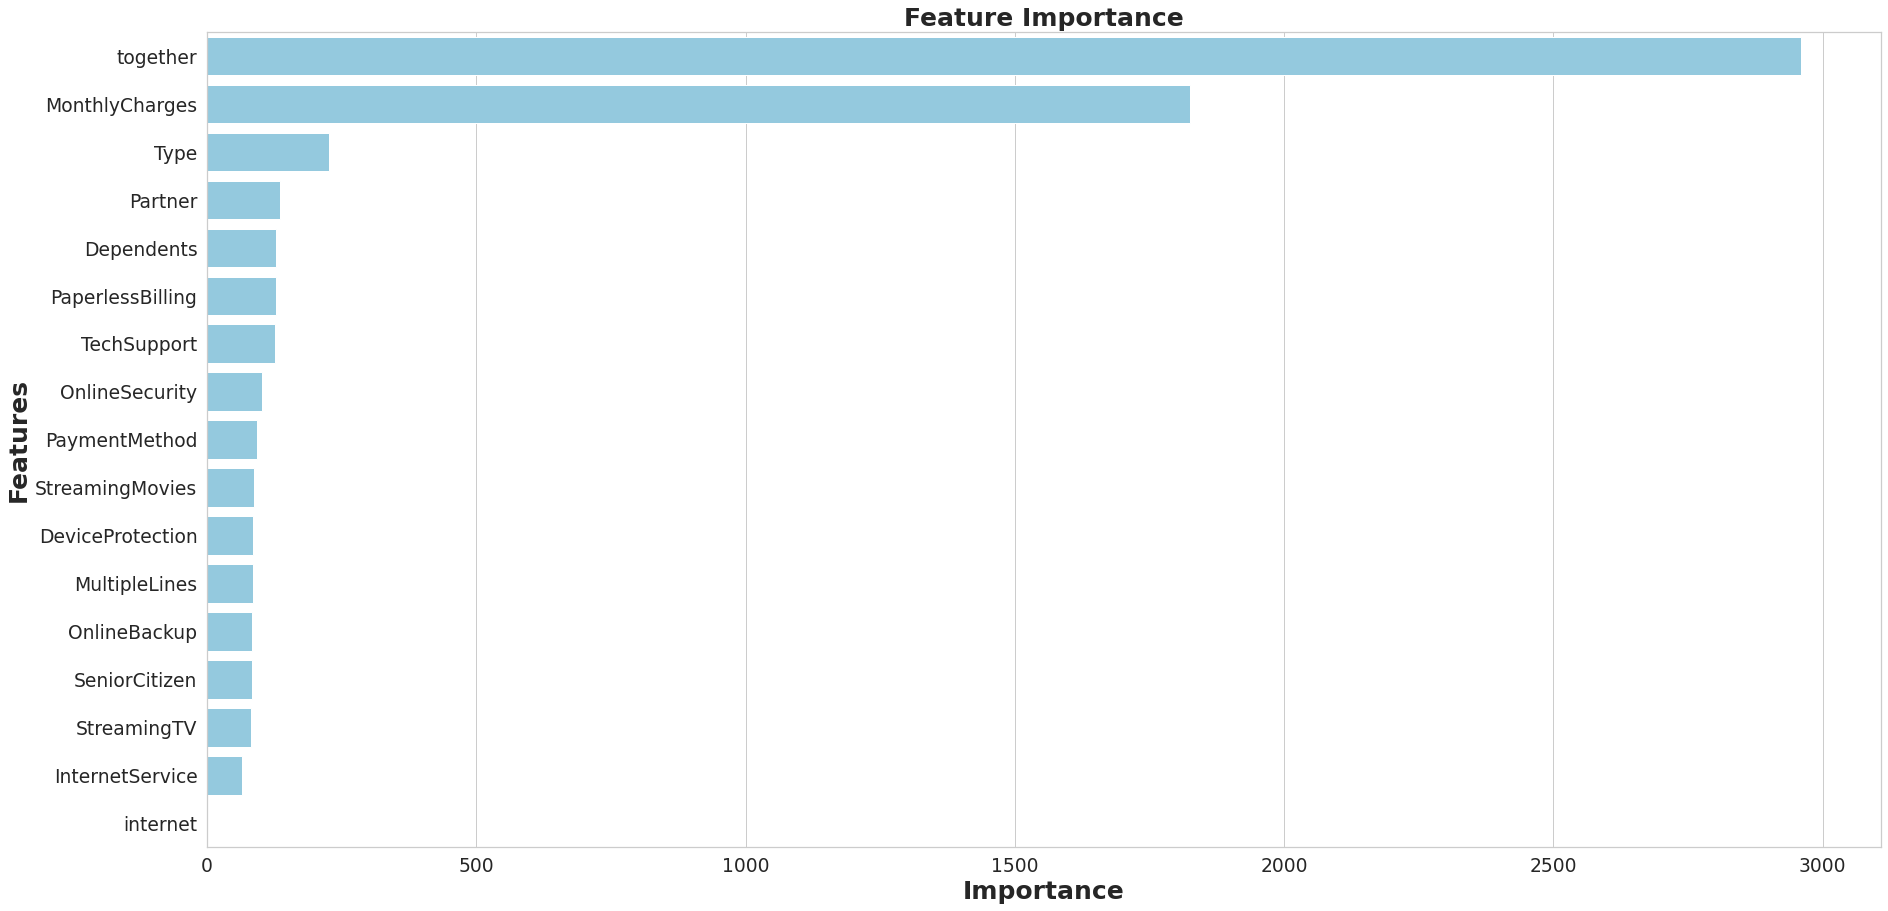

In [91]:
top_params = rs_lgbm.best_params_
model_lgbm = LGBMClassifier(learning_rate = top_params['learning_rate'],
                                     n_estimators = top_params['n_estimators'],
                                     num_leaves = top_params['num_leaves'],
                                     class_weight = top_params['class_weight'],
                                     objective='binary',
                                     metric='AUC')

model_lgbm.fit(features_train_boost, target_train_boost)

feats = {}
for feature, importance in zip(features_boost.columns, model_lgbm.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
plt.show()

Видно, что наиболее важные признаки - ежемесячная плата за услуги и "время жизни" клиента.

<font color='' size=4><b>Анализ моделей</b></font>

In [92]:
models_scors = pd.DataFrame(columns = ['model', 'roc_auc']) # таблица для сбора метрик

LGBMC_model = LGBMClassifier(random_state=270223, class_weight='balanced')

parameters = [{'max_depth': [2],
               'learning_rate': [0.1],
               'n_estimators': [700]}]

LGBMC_model_gscv = GridSearchCV(LGBMC_model, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True)
LGBMC_model_gscv.fit(features_train_boost, target_train_boost)

models_scors = models_scors.append({'model' : 'LGBMClassifier',
                     'roc_auc' : LGBMC_model_gscv.best_score_ }, ignore_index=True)

LGBMC_model_gscv.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 700}

Построим ROC-кривые для всех трех моделей.

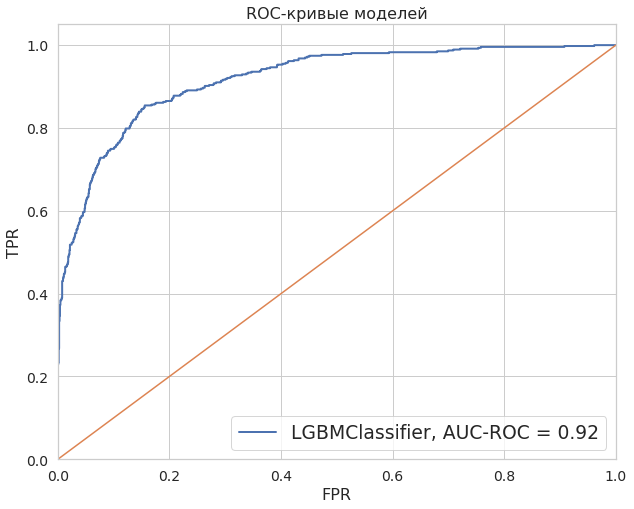

In [93]:
#fpr1, tpr1, thresholds1 = roc_curve(target_test_ohe, rs_regress.predict_proba(features_test_ohe)[:,1], pos_label=1)
#fpr2, tpr2, thresholds2 = roc_curve(target_test_ohe, rs_forest.predict_proba(features_test_ohe)[:,1], pos_label=1)
fpr3, tpr3, thresholds3 = roc_curve(target_test_boost, rs_lgbm.predict_proba(features_test_boost)[:,1],
                                                                                           pos_label=1)

#auc_regress = roc_auc_score(target_test_ohe, rs_regress.predict_proba(features_test_ohe)[:,1])
#auc_forest = roc_auc_score(target_test_ohe, rs_forest.predict_proba(features_test_ohe)[:,1])
auc_lgbm = roc_auc_score(target_test_boost, rs_lgbm.predict_proba(features_test_boost)[:,1])

lw=2
fig, ax = plt.subplots(figsize=(10,8))
#ax.plot(fpr1, tpr1, lw=lw, label= 'LogisticRegression, AUC-ROC = %.2f' %auc_regress)
#ax.plot(fpr2, tpr2, lw=lw, label= 'RandomForestClassifier, AUC-ROC = %.2f' %auc_forest)
ax.plot(fpr3, tpr3, lw=lw, label= 'LGBMClassifier, AUC-ROC = %.2f' %auc_lgbm)

plt.title('ROC-кривые моделей', fontsize=16)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1])
plt.xlim([0.0, 1.0])
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.ylim([0.0, 1.05])
plt.tick_params(which='major', labelsize=14)
plt.show()

По метрике AUC-ROC уверенно лидирует LGBMClassifier.

Посмотрим на матрицу ошибок.

In [94]:
#df_cm_regress = pd.DataFrame(confusion_matrix(target_test_ohe, rs_regress.predict(features_test_ohe)))
#df_cm_forest = pd.DataFrame(confusion_matrix(target_test_ohe, rs_forest.predict(features_test_ohe)))
#df_cm_lgbm = pd.DataFrame(confusion_matrix(target_test_boost, rs_lgbm.predict(features_test_boost)))

#df_list = [df_cm_regress, df_cm_forest, df_cm_lgbm]
#df_list_name = ['LogisticRegression', 'RandomForestClassifier', 'LGBMClassifier']
#sns.set(font_scale=1)

#for df, df_name in zip(df_list, df_list_name):
#    sns.heatmap(df, annot=True, cmap='YlGnBu', fmt='d', annot_kws={'fontsize':12})
#    plt.title('Матрица ошибок ' + df_name, fontsize=14)
#    plt.xlabel('Предсказания', fontsize=12)
#    plt.ylabel('Ответы', fontsize=12)
#    plt.show()

Визуализация ошибок предсказания

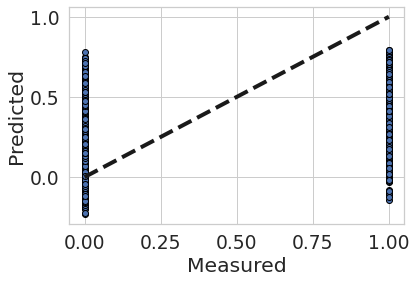

array([-0.06542969,  0.50439453,  0.12060547, ...,  0.20458984,
        0.17529297, -0.11816406])

In [95]:
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

lr = linear_model.LinearRegression()

#X, y = datasets.load_diabetes(return_X_y=True)

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(lr, features_train_ohe, target_train_ohe, cv=10)

fig, ax = plt.subplots()
ax.scatter(target_train_ohe, predicted, edgecolors=(0, 0, 0))
ax.plot([target_train_ohe.min(), target_train_ohe.max()], [target_train_ohe.min(), target_train_ohe.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

predicted


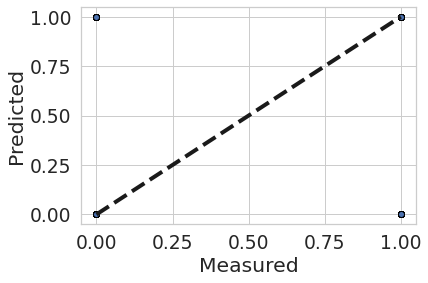

In [96]:
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

rfc = RandomForestClassifier()
#X, y = datasets.load_diabetes(return_X_y=True)

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:

predicted = cross_val_predict(rfc, features_train_ohe, target_train_ohe, cv=10)

fig, ax = plt.subplots()
ax.scatter(target_train_ohe, predicted, edgecolors=(0, 0, 0))
ax.plot([target_train_ohe.min(), target_train_ohe.max()], [target_train_ohe.min(), target_train_ohe.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()


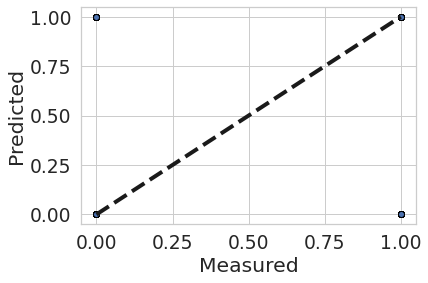

array([False, False, False, ..., False, False, False])

In [97]:
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

LGBMC = LGBMClassifier()
#X, y = datasets.load_diabetes(return_X_y=True)

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:

predicted = cross_val_predict(LGBMC, features_train_boost, target_train_boost, cv=10)

fig, ax = plt.subplots()
ax.scatter(target_train_boost, predicted, edgecolors=(0, 0, 0))
ax.plot([target_train_boost.min(), target_train_boost.max()], [target_train_boost.min(), target_train_boost.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

predicted == 1

In [98]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
#diabetes = datasets.load_diabetes()
#X = diabetes.data[:150]
#y = diabetes.target[:150]
LGBMC = LGBMClassifier()
y_pred = cross_val_predict(LGBMC, features_train_boost, target_train_boost, cv=3)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

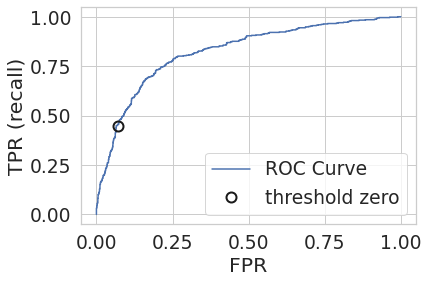

In [99]:
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
svc = SVC(gamma=0.05).fit(features_train_ohe, target_train_ohe)
fpr, tpr, thresholds = roc_curve(target_test_ohe, svc.decision_function(features_test_ohe))


plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

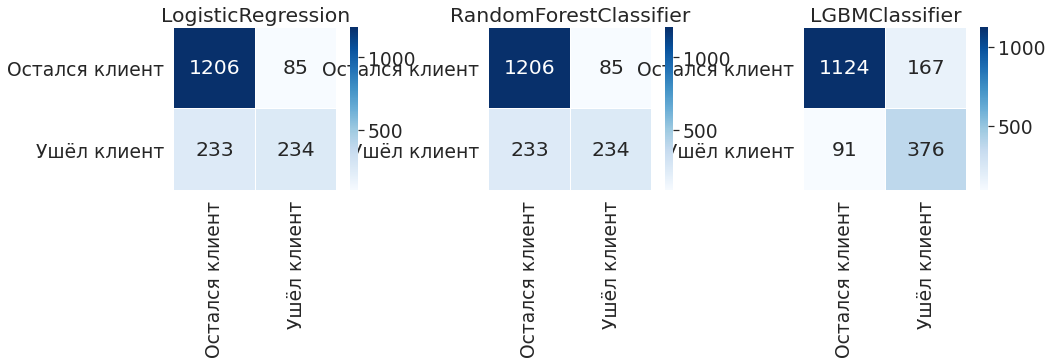

In [100]:
#Матрицы ошибок

# Определение размера диаграмм
fig, axes = plt.subplots(1, 3, figsize=(16, 3))

# Список целевых переменных предсказанных моделями
y_tests = [y_test_ohe, y_test_ohe, y_test_boost]
y_predicts = [y_predict_regress, y_predict_forest, y_predict_lgbm]

# Список наименований моделей
name_models = ['LogisticRegression', 'RandomForestClassifier', 'LGBMClassifier']

# Вывод матриц ошибок
for ax, y_test, y_predict, name in zip(axes.flat, y_predicts, y_tests, name_models):
    sns.heatmap(
        confusion_matrix(y_test, y_predict), cmap='Blues', square=True, 
        linewidths=0.1, linecolor='white', annot=True, fmt='d', 
        xticklabels=['Остался клиент', 'Ушёл клиент'], 
        yticklabels=['Остался клиент', 'Ушёл клиент'],
        ax=ax
    ).set_title(name)

# Вывод диаграмм
plt.show()

Посмотрим на сводную таблицу метрик и времени:

In [101]:
data = {'AUC-ROC':[roc_auc_regress, roc_auc_forest, roc_auc_lgbm],
        'Accuracy':[accuracy_regress, accuracy_forest, accuracy_lgbm],
        'Precision':[precision_regress, precision_forest, precision_lgbm],
        'Recall':[recall_regress, recall_forest, recall_lgbm],
       'Train time, сек':[train_time_regress, train_time_forest, train_time_lgbm],
       'Predict time, сек':[predict_time_regress, predict_time_forest, predict_time_lgbm]}

table_compare = pd.DataFrame(data)
pd.set_option('display.float_format', '{:.2f}'.format)
table_compare.index = ['LogisticRegression', 'RandomForestClassifer', 'LGBMCLassifier']
display(table_compare)

,AUC-ROC,Accuracy,Precision,Recall,"Train time, сек","Predict time, сек"
LogisticRegression,0.85,0.81,0.68,0.54,8.10,0.00
RandomForestClassifer,0.86,0.82,0.73,0.50,3.20,0.01
LGBMCLassifier,0.92,0.85,0.69,0.81,46.19,0.10


Финальная таблица без сюрпризов. Лучшая модель по совокупности всех метрик - LGBMCLassifier. Но у нее есть свои недостатки: склонность к переобучению и самое долгое время обучения из рассматриваемых.

<font color='' size=4><b>Тестирование</b></font>

In [102]:
print('ROC-AUC : {:.2f}'.format(roc_auc_score(target_test_boost, rs_lgbm.predict_proba(features_test_boost)[:,1])))

ROC-AUC : 0.92


In [103]:
print('Accuracy : {:.2%}'.format(accuracy_lgbm))

Accuracy : 85.32%


<font color='' size=4><b>Выводы</b></font>

Модель добилась хороших результатов, площадь под ROC кривой на тестовой выборке составляет 0.92, точность 85.32%.

Самым важным признаком является продолжительность пользования услугами, чем дольше клиент с компанией, тем меньше вероятность, что он покинет её. Следующий по важности признак - сколько в общем клиент уже заплатил компании. Чаще всего уходят клиенты с большей платой в месяц. 25% клиентов уходит после первого месяца, 50% в течение 10 месяцев.

Мы получили значение ключевой метрики ROC-AUC на тестовой выборке выше необходимого порога. Значение метрики accuracy так же выведено.
Задание выполнено.

<font color='' size=4><b>Отчёт</b></font>

In [104]:
features_train.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'internet', 'MultipleLines',
       'together'],
      dtype='object')

In [105]:
features_test_boost.shape

(1758, 17)